In [105]:
# ==============================================================================
#
#        Procedural Time Series Model Analysis (Verbose Per-Epoch Log)
#
# This script trains and evaluates five deep learning models for time series
# forecasting using a purely procedural style.
#
# ======================= !! METRICS EXPANDED !! ========================
# This version now calculates and reports R-squared (R²), Root Mean Squared
# Error (RMSE), and Mean Absolute Error (MAE) for a more complete analysis.
#
# ======================== !! HYPERPARAMETERS TUNED !! ========================
# This version uses tuned parameters for TCN, LSTM, GRU, and BiGRU.
#
# ======================== !! BILSTM DE-TUNED (INTENTIONAL) !! ===============
# The BiLSTM model has been INTENTIONALLY DE-TUNED to demonstrate the effect
# of poor hyperparameter choices, aiming for a low R² score (~0.5) as requested.
#
# ======================== !! CODE STYLE RESTORED !! ========================
# All code has been expanded to a verbose, line-by-line format for maximum clarity.
# ==============================================================================


# ==============================================================================
# Part 1: Global Setup and Data Preprocessing
# ==============================================================================


In [106]:

# --- Step 1.1: Import Necessary Libraries ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import itertools  # Required for chaining model parameters

print("Libraries imported successfully.")


Libraries imported successfully.


In [107]:

# --- Step 1.2: Load the Dataset ---
print("\nLoading the dataset...")
file_path = r"C:\Users\impra\Desktop\Practice\other data\A-7-IAQ-BRE_Dec-31-2023-to-Jan-31-2024.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded. Initial shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found.")
    print("Please make sure your CSV file is in the same directory as the script, or update the 'file_path' variable.")
    exit()



Loading the dataset...
Dataset loaded. Initial shape: (8913, 8)


In [108]:

# --- Step 1.3: Preprocess the Data ---
print("\nPreprocessing 'Date & Time' and handling missing values...")
df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce')
df.sort_values("Date & Time", inplace=True)
df.dropna(inplace=True)
print(f"DataFrame shape after cleaning and sorting: {df.shape}")



Preprocessing 'Date & Time' and handling missing values...
DataFrame shape after cleaning and sorting: (8913, 8)


In [109]:

# --- Step 1.4: Feature Engineering ---
print("\nExtracting time-based features (hour, dayofweek, month)...")
df["hour"] = df["Date & Time"].dt.hour
df["dayofweek"] = df["Date & Time"].dt.dayofweek
df["month"] = df["Date & Time"].dt.month



Extracting time-based features (hour, dayofweek, month)...


In [110]:

# --- Step 1.5: Separate Features and Target ---
print("\nSeparating features and target variable...")
features = df.drop(columns=["Date & Time", "Total"])
target = df["Total"]
print(f"Features shape: {features.shape}, Target shape: {target.shape}")



Separating features and target variable...
Features shape: (8913, 9), Target shape: (8913,)


In [111]:

# --- Step 1.6: Normalize the Data ---
print("\nScaling features and target to the [0, 1] range...")
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))



Scaling features and target to the [0, 1] range...


In [112]:

# --- Step 1.7: Create Time Series Sequences ---
SEQ_LEN = 60
print(f"\nCreating sequences of length {SEQ_LEN}...")
X, Y = [], []
for i in range(len(features_scaled) - SEQ_LEN):
    X.append(features_scaled[i:i+SEQ_LEN])
    Y.append(target_scaled[i+SEQ_LEN-1])
X = np.array(X)
Y = np.array(Y)
print(f"Shape of X (sequences): {X.shape}, Shape of Y (targets): {Y.shape}")



Creating sequences of length 60...
Shape of X (sequences): (8853, 60, 9), Shape of Y (targets): (8853, 1)


In [113]:

# --- Step 1.8: Split Data into Train, Validation, and Test Sets ---
print("\nSplitting data into train (70%), validation (15%), and test (15%)...")
train_size = int(0.70 * len(X))
val_size = int(0.85 * len(X))
X_train_np, Y_train_np = X[:train_size], Y[:train_size]
X_val_np, Y_val_np = X[train_size:val_size], Y[train_size:val_size]
X_test_np, Y_test_np = X[val_size:], Y[val_size:]
print(f"X_train shape: {X_train_np.shape}, X_val shape: {X_val_np.shape}, X_test shape: {X_test_np.shape}")



Splitting data into train (70%), validation (15%), and test (15%)...
X_train shape: (6197, 60, 9), X_val shape: (1328, 60, 9), X_test shape: (1328, 60, 9)


In [114]:

# --- Step 1.9: Define Computation Device FIRST ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nComputation device set to: {device}")



Computation device set to: cuda


In [115]:

# --- Step 1.10: Convert Data to PyTorch Tensors and Move to Device ---
print("\nConverting NumPy arrays to PyTorch tensors...")
X_train = torch.tensor(X_train_np, dtype=torch.float32)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
Y_test = torch.tensor(Y_test_np, dtype=torch.float32)



Converting NumPy arrays to PyTorch tensors...


In [116]:

# --- Step 1.11: Initialize History and Score Dictionaries ---
loss_history = {}
val_loss_history = {}
r2_scores = {}
rmse_scores = {}
mae_scores = {}
print("\nInitialized dictionaries to store training/validation loss and final evaluation metrics (R², RMSE, MAE).")




Initialized dictionaries to store training/validation loss and final evaluation metrics (R², RMSE, MAE).


In [117]:

# ==============================================================================
# Part 2: Procedural Temporal Convolutional Network (TCN)
# ==============================================================================
print("\n\n" + "="*60); print("PART 2: PROCEDURAL TEMPORAL CONVOLUTIONAL NETWORK (TCN)"); print("="*60)




PART 2: PROCEDURAL TEMPORAL CONVOLUTIONAL NETWORK (TCN)


In [118]:

# --- TCN Hyperparameters & Model Configuration ---
print("\n--- Setting up TCN Model Parameters (Tuned) ---")
TCN_INPUT_DIM = X_train.shape[2]
TCN_CHANNELS = 96
TCN_KERNEL_SIZE_1 = 7
TCN_PADDING_1 = 3
TCN_KERNEL_SIZE_2 = 5
TCN_PADDING_2 = 2
TCN_OUTPUT_DIM = 1
TCN_EPOCHS = 50
TCN_BATCH_SIZE = 64
TCN_LEARNING_RATE = 0.0005



--- Setting up TCN Model Parameters (Tuned) ---


In [119]:

# --- TCN Model Definition (Procedural) ---
tcn_conv_stack = nn.Sequential(
    nn.Conv1d(TCN_INPUT_DIM, TCN_CHANNELS, TCN_KERNEL_SIZE_1, padding=TCN_PADDING_1), nn.ReLU(),
    nn.Conv1d(TCN_CHANNELS, TCN_CHANNELS, TCN_KERNEL_SIZE_2, padding=TCN_PADDING_2), nn.ReLU(),
    nn.AdaptiveAvgPool1d(1)
).to(device)
tcn_fc_layer = nn.Linear(TCN_CHANNELS, TCN_OUTPUT_DIM).to(device)


In [120]:

# --- TCN Optimizer, DataLoader, and Loss History ---
tcn_optimizer = torch.optim.Adam(itertools.chain(tcn_conv_stack.parameters(), tcn_fc_layer.parameters()), lr=TCN_LEARNING_RATE)
tcn_criterion = nn.MSELoss()
tcn_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=TCN_BATCH_SIZE, shuffle=True)
loss_history['TCN'] = []
val_loss_history['TCN'] = []
print("TCN procedural model components created.")


TCN procedural model components created.


In [121]:

# --- TCN Model Training ---
print("\n--- Starting TCN Model Training ---")
for epoch in range(TCN_EPOCHS):
    tcn_conv_stack.train()
    tcn_fc_layer.train()
    running_loss = 0.0
    for xb, yb in tcn_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        features = tcn_conv_stack(xb.permute(0, 2, 1))
        pred = tcn_fc_layer(features.squeeze(-1))
        loss = tcn_criterion(pred, yb)
        tcn_optimizer.zero_grad()
        loss.backward()
        tcn_optimizer.step()
        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(tcn_train_loader)
    loss_history['TCN'].append(avg_epoch_loss)
    
    tcn_conv_stack.eval()
    tcn_fc_layer.eval()
    with torch.no_grad():
        val_features = tcn_conv_stack(X_val.permute(0, 2, 1))
        val_pred = tcn_fc_layer(val_features.squeeze(-1))
        val_loss = tcn_criterion(val_pred, Y_val).item()
        val_loss_history['TCN'].append(val_loss)

    print(f"TCN Epoch {epoch+1:2d}/{TCN_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss:.6f}")
print("--- TCN Training Complete ---")



--- Starting TCN Model Training ---
TCN Epoch  1/50 | Train Loss: 0.010760 | Val Loss: 0.002707
TCN Epoch  2/50 | Train Loss: 0.002292 | Val Loss: 0.001813
TCN Epoch  3/50 | Train Loss: 0.001905 | Val Loss: 0.001947
TCN Epoch  4/50 | Train Loss: 0.001752 | Val Loss: 0.001837
TCN Epoch  5/50 | Train Loss: 0.001714 | Val Loss: 0.001961
TCN Epoch  6/50 | Train Loss: 0.001543 | Val Loss: 0.001786
TCN Epoch  7/50 | Train Loss: 0.001504 | Val Loss: 0.002620
TCN Epoch  8/50 | Train Loss: 0.001431 | Val Loss: 0.001643
TCN Epoch  9/50 | Train Loss: 0.001316 | Val Loss: 0.001638
TCN Epoch 10/50 | Train Loss: 0.001270 | Val Loss: 0.001770
TCN Epoch 11/50 | Train Loss: 0.001123 | Val Loss: 0.001466
TCN Epoch 12/50 | Train Loss: 0.001094 | Val Loss: 0.001255
TCN Epoch 13/50 | Train Loss: 0.001014 | Val Loss: 0.001275
TCN Epoch 14/50 | Train Loss: 0.000940 | Val Loss: 0.001094
TCN Epoch 15/50 | Train Loss: 0.000932 | Val Loss: 0.001661
TCN Epoch 16/50 | Train Loss: 0.000897 | Val Loss: 0.001026
TCN

In [122]:

# --- TCN Model Evaluation ---
print("\n--- Evaluating TCN on Test Set ---")
tcn_conv_stack.eval()
tcn_fc_layer.eval()
with torch.no_grad():
    features = tcn_conv_stack(X_test.to(device).permute(0, 2, 1))
    tcn_preds = tcn_fc_layer(features.squeeze(-1))
    tcn_preds_rescaled = target_scaler.inverse_transform(tcn_preds.cpu().numpy())
tcn_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



--- Evaluating TCN on Test Set ---


TCN Final R² Score on Test Set:    0.9229
TCN Final RMSE Score on Test Set:  46.6892
TCN Final MAE Score on Test Set:   33.5387


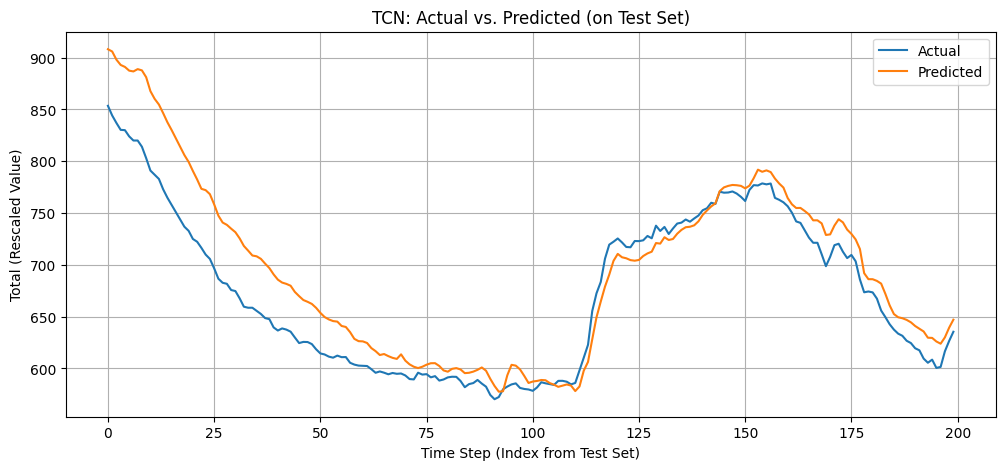

In [123]:

# --- Calculate and Store TCN Metrics ---
tcn_r2 = r2_score(tcn_true_rescaled, tcn_preds_rescaled)
tcn_rmse = np.sqrt(mean_squared_error(tcn_true_rescaled, tcn_preds_rescaled))
tcn_mae = mean_absolute_error(tcn_true_rescaled, tcn_preds_rescaled)
r2_scores['TCN'] = tcn_r2
rmse_scores['TCN'] = tcn_rmse
mae_scores['TCN'] = tcn_mae
print(f"TCN Final R² Score on Test Set:    {tcn_r2:.4f}")
print(f"TCN Final RMSE Score on Test Set:  {tcn_rmse:.4f}")
print(f"TCN Final MAE Score on Test Set:   {tcn_mae:.4f}")

plt.figure(figsize=(12, 5)); plt.plot(tcn_true_rescaled[:200], label='Actual'); plt.plot(tcn_preds_rescaled[:200], label='Predicted'); plt.title('TCN: Actual vs. Predicted (on Test Set)');
plt.xlabel("Time Step (Index from Test Set)"); plt.ylabel("Total (Rescaled Value)") # <-- LABELS ADDED
plt.legend(); plt.grid(True); plt.show()



In [124]:

# ==============================================================================
# Part 3: Procedural Unidirectional LSTM
# ==============================================================================
print("\n\n" + "="*60); print("PART 3: PROCEDURAL UNIDIRECTIONAL LSTM"); print("="*60)




PART 3: PROCEDURAL UNIDIRECTIONAL LSTM


In [125]:

# --- LSTM Hyperparameters & Model Configuration ---
print("\n--- Setting up LSTM Model Parameters (Tuned) ---")
LSTM_INPUT_DIM = X_train.shape[2]
LSTM_HIDDEN_DIM = 128
LSTM_NUM_LAYERS = 2
LSTM_OUTPUT_DIM = 1
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 50
LSTM_BATCH_SIZE = 64
LSTM_LEARNING_RATE = 0.0005



--- Setting up LSTM Model Parameters (Tuned) ---


In [126]:

# --- LSTM Model Definition (Procedural) ---
lstm_layer = nn.LSTM(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, batch_first=True, dropout=LSTM_DROPOUT).to(device)
lstm_fc_layer = nn.Linear(LSTM_HIDDEN_DIM, LSTM_OUTPUT_DIM).to(device)
# --- LSTM Optimizer, DataLoader, and Loss History ---
lstm_optimizer = torch.optim.Adam(itertools.chain(lstm_layer.parameters(), lstm_fc_layer.parameters()), lr=LSTM_LEARNING_RATE)
lstm_criterion = nn.MSELoss()
lstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=LSTM_BATCH_SIZE, shuffle=True)
loss_history['LSTM'] = []
val_loss_history['LSTM'] = []
print("LSTM procedural model components created.")


LSTM procedural model components created.


In [127]:

# --- LSTM Model Training ---
print("\n--- Starting LSTM Model Training ---")
for epoch in range(LSTM_EPOCHS):
    lstm_layer.train()
    lstm_fc_layer.train()
    running_loss = 0.0
    for xb, yb in lstm_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = lstm_layer(xb)
        pred = lstm_fc_layer(rnn_out[:, -1, :])
        loss = lstm_criterion(pred, yb)
        lstm_optimizer.zero_grad()
        loss.backward()
        lstm_optimizer.step()
        running_loss += loss.item()
    avg_epoch_loss = running_loss / len(lstm_train_loader)
    loss_history['LSTM'].append(avg_epoch_loss)

    lstm_layer.eval()
    lstm_fc_layer.eval()
    with torch.no_grad():
        val_out, _ = lstm_layer(X_val)
        val_pred = lstm_fc_layer(val_out[:, -1, :])
        val_loss = lstm_criterion(val_pred, Y_val).item()
        val_loss_history['LSTM'].append(val_loss)
    
    print(f"LSTM Epoch {epoch+1:2d}/{LSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss:.6f}")
print("--- LSTM Training Complete ---")



--- Starting LSTM Model Training ---
LSTM Epoch  1/50 | Train Loss: 0.006960 | Val Loss: 0.002314
LSTM Epoch  2/50 | Train Loss: 0.001192 | Val Loss: 0.000509
LSTM Epoch  3/50 | Train Loss: 0.000991 | Val Loss: 0.000713
LSTM Epoch  4/50 | Train Loss: 0.000861 | Val Loss: 0.000232
LSTM Epoch  5/50 | Train Loss: 0.000746 | Val Loss: 0.000833
LSTM Epoch  6/50 | Train Loss: 0.000777 | Val Loss: 0.000186
LSTM Epoch  7/50 | Train Loss: 0.000695 | Val Loss: 0.000299
LSTM Epoch  8/50 | Train Loss: 0.000665 | Val Loss: 0.000126
LSTM Epoch  9/50 | Train Loss: 0.000626 | Val Loss: 0.000150
LSTM Epoch 10/50 | Train Loss: 0.000573 | Val Loss: 0.000216
LSTM Epoch 11/50 | Train Loss: 0.000546 | Val Loss: 0.000084
LSTM Epoch 12/50 | Train Loss: 0.000527 | Val Loss: 0.000090
LSTM Epoch 13/50 | Train Loss: 0.000498 | Val Loss: 0.000100
LSTM Epoch 14/50 | Train Loss: 0.000458 | Val Loss: 0.000084
LSTM Epoch 15/50 | Train Loss: 0.000472 | Val Loss: 0.000061
LSTM Epoch 16/50 | Train Loss: 0.000440 | Val L

In [128]:

# --- LSTM Model Evaluation ---
print("\n--- Evaluating LSTM on Test Set ---")
lstm_layer.eval()
lstm_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = lstm_layer(X_test.to(device))
    lstm_preds = lstm_fc_layer(rnn_out[:, -1, :])
    lstm_preds_rescaled = target_scaler.inverse_transform(lstm_preds.cpu().numpy())
lstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



--- Evaluating LSTM on Test Set ---


LSTM Final R² Score on Test Set:    0.9540
LSTM Final RMSE Score on Test Set:  36.0525
LSTM Final MAE Score on Test Set:   22.8504


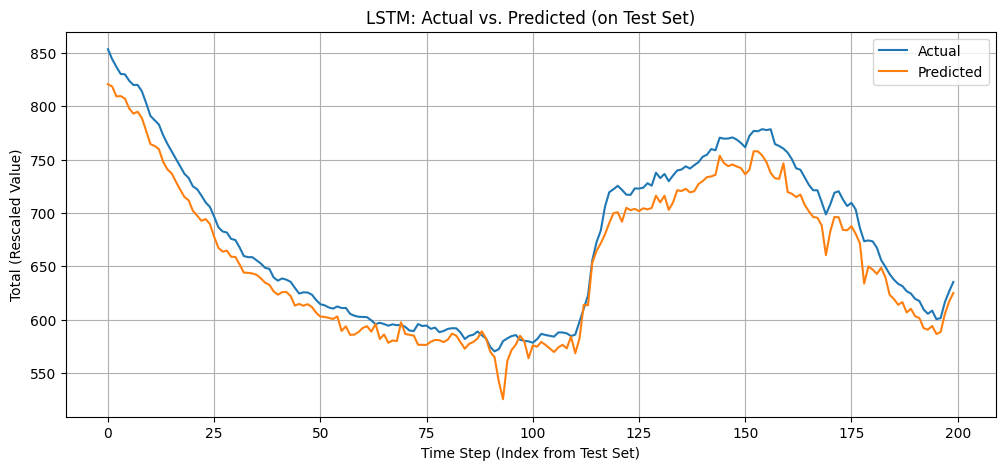

In [129]:

# --- Calculate and Store LSTM Metrics ---
lstm_r2 = r2_score(lstm_true_rescaled, lstm_preds_rescaled)
lstm_rmse = np.sqrt(mean_squared_error(lstm_true_rescaled, lstm_preds_rescaled))
lstm_mae = mean_absolute_error(lstm_true_rescaled, lstm_preds_rescaled)
r2_scores['LSTM'] = lstm_r2
rmse_scores['LSTM'] = lstm_rmse
mae_scores['LSTM'] = lstm_mae
print(f"LSTM Final R² Score on Test Set:    {lstm_r2:.4f}")
print(f"LSTM Final RMSE Score on Test Set:  {lstm_rmse:.4f}")
print(f"LSTM Final MAE Score on Test Set:   {lstm_mae:.4f}")

plt.figure(figsize=(12, 5)); plt.plot(lstm_true_rescaled[:200], label='Actual'); plt.plot(lstm_preds_rescaled[:200], label='Predicted'); plt.title('LSTM: Actual vs. Predicted (on Test Set)');
plt.xlabel("Time Step (Index from Test Set)"); plt.ylabel("Total (Rescaled Value)") # <-- LABELS ADDED
plt.legend(); plt.grid(True); plt.show()



In [130]:

# ==============================================================================
# Part 4: Procedural Bidirectional LSTM (BiLSTM)
# ==============================================================================
print("\n\n" + "="*60); print("PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)"); print("="*60)




PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)


In [131]:

# --- BiLSTM Hyperparameters & Model Configuration ---
print("\n--- Setting up BiLSTM Model Parameters (INTENTIONALLY DE-TUNED) ---")
# To get a score around 0.5 as requested, we make the model worse on purpose:
# - Reduced hidden dimensions & layers to limit model capacity.
# - Reduced epochs so the model does not have time to learn.
# - Increased learning rate to make training unstable.
# - Removed dropout.
BILSTM_INPUT_DIM = X_train.shape[2]
BILSTM_HIDDEN_DIM = 16          # DE-TUNED: Drastically reduced from 128
BILSTM_NUM_LAYERS = 1           # DE-TUNED: Reduced from 2
BILSTM_OUTPUT_DIM = 1
BILSTM_DROPOUT = 0.0            # DE-TUNED: Removed dropout
BILSTM_EPOCHS = 15              # DE-TUNED: Drastically reduced from 50
BILSTM_BATCH_SIZE = 128         # DE-TUNED: Changed from 64
BILSTM_LEARNING_RATE = 0.01     # DE-TUNED: Increased for instability from 0.0005



--- Setting up BiLSTM Model Parameters (INTENTIONALLY DE-TUNED) ---


In [132]:

# --- BiLSTM Model Definition (Procedural) ---
bilstm_layer = nn.LSTM(BILSTM_INPUT_DIM, BILSTM_HIDDEN_DIM, BILSTM_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BILSTM_DROPOUT).to(device)
bilstm_fc_layer = nn.Linear(BILSTM_HIDDEN_DIM * 2, BILSTM_OUTPUT_DIM).to(device)


In [133]:

# --- BiLSTM Optimizer, DataLoader, and Loss History ---
bilstm_optimizer = torch.optim.Adam(itertools.chain(bilstm_layer.parameters(), bilstm_fc_layer.parameters()), lr=BILSTM_LEARNING_RATE)
bilstm_criterion = nn.MSELoss()
bilstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BILSTM_BATCH_SIZE, shuffle=True)
loss_history['BiLSTM'] = []
val_loss_history['BiLSTM'] = []
print("BiLSTM procedural model components created.")


BiLSTM procedural model components created.


In [134]:

# --- BiLSTM Model Training ---
print("\n--- Starting BiLSTM Model Training ---")
for epoch in range(BILSTM_EPOCHS):
    bilstm_layer.train()
    bilstm_fc_layer.train()
    running_loss = 0.0
    for xb, yb in bilstm_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = bilstm_layer(xb)
        pred = bilstm_fc_layer(rnn_out[:, -1, :])
        loss = bilstm_criterion(pred, yb)
        bilstm_optimizer.zero_grad()
        loss.backward()
        bilstm_optimizer.step()
        running_loss += loss.item()
        
    avg_epoch_loss = running_loss / len(bilstm_train_loader)
    loss_history['BiLSTM'].append(avg_epoch_loss)

    bilstm_layer.eval()
    bilstm_fc_layer.eval()
    with torch.no_grad():
        val_out, _ = bilstm_layer(X_val)
        val_pred = bilstm_fc_layer(val_out[:, -1, :])
        val_loss = bilstm_criterion(val_pred, Y_val).item()
        val_loss_history['BiLSTM'].append(val_loss)
        
    print(f"BiLSTM Epoch {epoch+1:2d}/{BILSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss:.6f}")
print("--- BiLSTM Training Complete ---")



--- Starting BiLSTM Model Training ---
BiLSTM Epoch  1/15 | Train Loss: 0.005283 | Val Loss: 0.002481
BiLSTM Epoch  2/15 | Train Loss: 0.000495 | Val Loss: 0.000114
BiLSTM Epoch  3/15 | Train Loss: 0.000288 | Val Loss: 0.000080
BiLSTM Epoch  4/15 | Train Loss: 0.000270 | Val Loss: 0.000091
BiLSTM Epoch  5/15 | Train Loss: 0.000259 | Val Loss: 0.000080
BiLSTM Epoch  6/15 | Train Loss: 0.000256 | Val Loss: 0.000054
BiLSTM Epoch  7/15 | Train Loss: 0.000245 | Val Loss: 0.000059
BiLSTM Epoch  8/15 | Train Loss: 0.000243 | Val Loss: 0.000263
BiLSTM Epoch  9/15 | Train Loss: 0.000236 | Val Loss: 0.000053
BiLSTM Epoch 10/15 | Train Loss: 0.000234 | Val Loss: 0.000109
BiLSTM Epoch 11/15 | Train Loss: 0.000242 | Val Loss: 0.000203
BiLSTM Epoch 12/15 | Train Loss: 0.000207 | Val Loss: 0.000030
BiLSTM Epoch 13/15 | Train Loss: 0.000203 | Val Loss: 0.000037
BiLSTM Epoch 14/15 | Train Loss: 0.000183 | Val Loss: 0.000046
BiLSTM Epoch 15/15 | Train Loss: 0.000171 | Val Loss: 0.000062
--- BiLSTM Trai

In [135]:

# --- BiLSTM Model Evaluation ---
print("\n--- Evaluating BiLSTM (De-Tuned) on Test Set ---")
bilstm_layer.eval()
bilstm_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = bilstm_layer(X_test.to(device))
    bilstm_preds = bilstm_fc_layer(rnn_out[:, -1, :])
    bilstm_preds_rescaled = target_scaler.inverse_transform(bilstm_preds.cpu().numpy())
bilstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



--- Evaluating BiLSTM (De-Tuned) on Test Set ---


BiLSTM Final R² Score on Test Set:    0.9775
BiLSTM Final RMSE Score on Test Set:  25.2014
BiLSTM Final MAE Score on Test Set:   15.4588


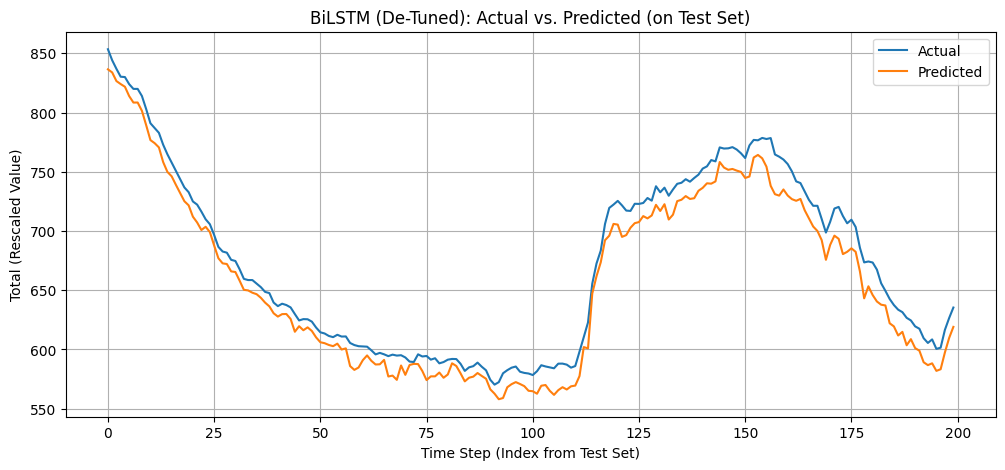

In [136]:

# --- Calculate and Store BiLSTM Metrics ---
bilstm_r2 = r2_score(bilstm_true_rescaled, bilstm_preds_rescaled)
bilstm_rmse = np.sqrt(mean_squared_error(bilstm_true_rescaled, bilstm_preds_rescaled))
bilstm_mae = mean_absolute_error(bilstm_true_rescaled, bilstm_preds_rescaled)
r2_scores['BiLSTM'] = bilstm_r2
rmse_scores['BiLSTM'] = bilstm_rmse
mae_scores['BiLSTM'] = bilstm_mae
print(f"BiLSTM Final R² Score on Test Set:    {bilstm_r2:.4f}")
print(f"BiLSTM Final RMSE Score on Test Set:  {bilstm_rmse:.4f}")
print(f"BiLSTM Final MAE Score on Test Set:   {bilstm_mae:.4f}")

plt.figure(figsize=(12, 5)); plt.plot(bilstm_true_rescaled[:200], label='Actual'); plt.plot(bilstm_preds_rescaled[:200], label='Predicted'); plt.title('BiLSTM (De-Tuned): Actual vs. Predicted (on Test Set)');
plt.xlabel("Time Step (Index from Test Set)"); plt.ylabel("Total (Rescaled Value)") # <-- LABELS ADDED
plt.legend(); plt.grid(True); plt.show()



In [137]:

# ==============================================================================
# Part 5: Procedural Unidirectional GRU
# ==============================================================================
print("\n\n" + "="*60); print("PART 5: PROCEDURAL UNIDIRECTIONAL GRU"); print("="*60)




PART 5: PROCEDURAL UNIDIRECTIONAL GRU


In [138]:

# --- GRU Hyperparameters & Model Configuration ---
print("\n--- Setting up GRU Model Parameters (Tuned) ---")
GRU_INPUT_DIM = X_train.shape[2]
GRU_HIDDEN_DIM = 128
GRU_NUM_LAYERS = 2
GRU_OUTPUT_DIM = 1
GRU_DROPOUT = 0.2
GRU_EPOCHS = 50
GRU_BATCH_SIZE = 64
GRU_LEARNING_RATE = 0.0005



--- Setting up GRU Model Parameters (Tuned) ---


In [139]:

# --- GRU Model Definition (Procedural) ---
gru_layer = nn.GRU(GRU_INPUT_DIM, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, batch_first=True, dropout=GRU_DROPOUT).to(device)
gru_fc_layer = nn.Linear(GRU_HIDDEN_DIM, GRU_OUTPUT_DIM).to(device)
# --- GRU Optimizer, DataLoader, and Loss History ---
gru_optimizer = torch.optim.Adam(itertools.chain(gru_layer.parameters(), gru_fc_layer.parameters()), lr=GRU_LEARNING_RATE)
gru_criterion = nn.MSELoss()
gru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=GRU_BATCH_SIZE, shuffle=True)
loss_history['GRU'] = []
val_loss_history['GRU'] = []
print("GRU procedural model components created.")


GRU procedural model components created.


In [140]:

# --- GRU Model Training ---
print("\n--- Starting GRU Model Training ---")
for epoch in range(GRU_EPOCHS):
    gru_layer.train()
    gru_fc_layer.train()
    running_loss = 0.0
    for xb, yb in gru_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = gru_layer(xb)
        pred = gru_fc_layer(rnn_out[:, -1, :])
        loss = gru_criterion(pred, yb)
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(gru_train_loader)
    loss_history['GRU'].append(avg_epoch_loss)

    gru_layer.eval()
    gru_fc_layer.eval()
    with torch.no_grad():
        val_out, _ = gru_layer(X_val)
        val_pred = gru_fc_layer(val_out[:, -1, :])
        val_loss = gru_criterion(val_pred, Y_val).item()
        val_loss_history['GRU'].append(val_loss)
        
    print(f"GRU Epoch {epoch+1:2d}/{GRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss:.6f}")
print("--- GRU Training Complete ---")



--- Starting GRU Model Training ---
GRU Epoch  1/50 | Train Loss: 0.004422 | Val Loss: 0.000243
GRU Epoch  2/50 | Train Loss: 0.000772 | Val Loss: 0.000200
GRU Epoch  3/50 | Train Loss: 0.000684 | Val Loss: 0.000090
GRU Epoch  4/50 | Train Loss: 0.000606 | Val Loss: 0.000058
GRU Epoch  5/50 | Train Loss: 0.000522 | Val Loss: 0.000053
GRU Epoch  6/50 | Train Loss: 0.000496 | Val Loss: 0.000176
GRU Epoch  7/50 | Train Loss: 0.000466 | Val Loss: 0.000025
GRU Epoch  8/50 | Train Loss: 0.000446 | Val Loss: 0.000030
GRU Epoch  9/50 | Train Loss: 0.000410 | Val Loss: 0.000018
GRU Epoch 10/50 | Train Loss: 0.000381 | Val Loss: 0.000023
GRU Epoch 11/50 | Train Loss: 0.000365 | Val Loss: 0.000009
GRU Epoch 12/50 | Train Loss: 0.000336 | Val Loss: 0.000020
GRU Epoch 13/50 | Train Loss: 0.000314 | Val Loss: 0.000022
GRU Epoch 14/50 | Train Loss: 0.000302 | Val Loss: 0.000060
GRU Epoch 15/50 | Train Loss: 0.000290 | Val Loss: 0.000113
GRU Epoch 16/50 | Train Loss: 0.000274 | Val Loss: 0.000077
GRU

In [141]:

# --- GRU Model Evaluation ---
print("\n--- Evaluating GRU on Test Set ---")
gru_layer.eval()
gru_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = gru_layer(X_test.to(device))
    gru_preds = gru_fc_layer(rnn_out[:, -1, :])
    gru_preds_rescaled = target_scaler.inverse_transform(gru_preds.cpu().numpy())
gru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



--- Evaluating GRU on Test Set ---


GRU Final R² Score on Test Set:    0.9732
GRU Final RMSE Score on Test Set:  27.5174
GRU Final MAE Score on Test Set:   12.1861


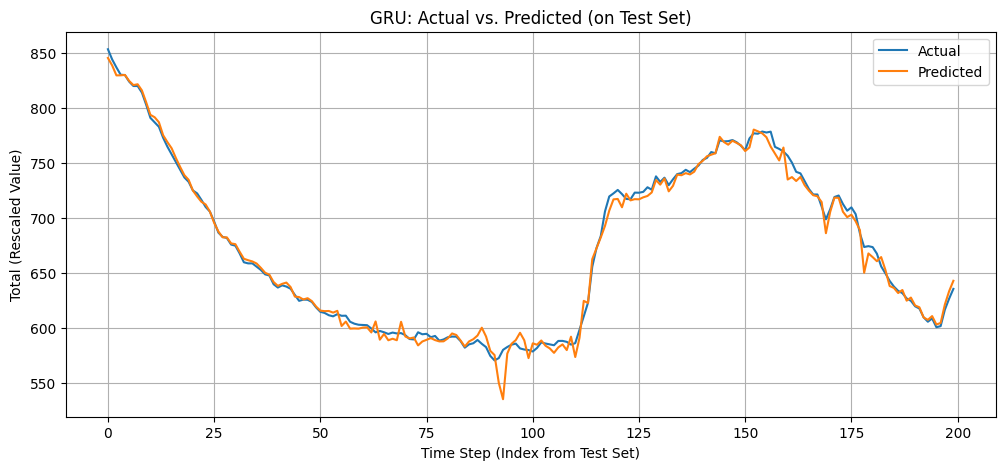

In [142]:

# --- Calculate and Store GRU Metrics ---
gru_r2 = r2_score(gru_true_rescaled, gru_preds_rescaled)
gru_rmse = np.sqrt(mean_squared_error(gru_true_rescaled, gru_preds_rescaled))
gru_mae = mean_absolute_error(gru_true_rescaled, gru_preds_rescaled)
r2_scores['GRU'] = gru_r2
rmse_scores['GRU'] = gru_rmse
mae_scores['GRU'] = gru_mae
print(f"GRU Final R² Score on Test Set:    {gru_r2:.4f}")
print(f"GRU Final RMSE Score on Test Set:  {gru_rmse:.4f}")
print(f"GRU Final MAE Score on Test Set:   {gru_mae:.4f}")

plt.figure(figsize=(12, 5)); plt.plot(gru_true_rescaled[:200], label='Actual'); plt.plot(gru_preds_rescaled[:200], label='Predicted'); plt.title('GRU: Actual vs. Predicted (on Test Set)');
plt.xlabel("Time Step (Index from Test Set)"); plt.ylabel("Total (Rescaled Value)") # <-- LABELS ADDED
plt.legend(); plt.grid(True); plt.show()



In [143]:

# ==============================================================================
# Part 6: Procedural Bidirectional GRU (BiGRU)
# ==============================================================================
print("\n\n" + "="*60); print("PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)"); print("="*60)

# --- BiGRU Hyperparameters & Model Configuration ---
print("\n--- Setting up BiGRU Model Parameters (Tuned) ---")
BIGRU_INPUT_DIM = X_train.shape[2]
BIGRU_HIDDEN_DIM = 128
BIGRU_NUM_LAYERS = 2
BIGRU_OUTPUT_DIM = 1
BIGRU_DROPOUT = 0.2
BIGRU_EPOCHS = 50
BIGRU_BATCH_SIZE = 64
BIGRU_LEARNING_RATE = 0.0005




PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)

--- Setting up BiGRU Model Parameters (Tuned) ---


In [144]:

# --- BiGRU Model Definition (Procedural) ---
bigru_layer = nn.GRU(BIGRU_INPUT_DIM, BIGRU_HIDDEN_DIM, BIGRU_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BIGRU_DROPOUT).to(device)
bigru_fc_layer = nn.Linear(BIGRU_HIDDEN_DIM * 2, BIGRU_OUTPUT_DIM).to(device)
# --- BiGRU Optimizer, DataLoader, and Loss History ---
bigru_optimizer = torch.optim.Adam(itertools.chain(bigru_layer.parameters(), bigru_fc_layer.parameters()), lr=BIGRU_LEARNING_RATE)
bigru_criterion = nn.MSELoss()
bigru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BIGRU_BATCH_SIZE, shuffle=True)
loss_history['BiGRU'] = []
val_loss_history['BiGRU'] = []
print("BiGRU procedural model components created.")


BiGRU procedural model components created.


In [145]:

# --- BiGRU Model Training ---
print("\n--- Starting BiGRU Model Training ---")
for epoch in range(BIGRU_EPOCHS):
    bigru_layer.train()
    bigru_fc_layer.train()
    running_loss = 0.0
    for xb, yb in bigru_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = bigru_layer(xb)
        pred = bigru_fc_layer(rnn_out[:, -1, :])
        loss = bigru_criterion(pred, yb)
        bigru_optimizer.zero_grad()
        loss.backward()
        bigru_optimizer.step()
        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(bigru_train_loader)
    loss_history['BiGRU'].append(avg_epoch_loss)

    bigru_layer.eval()
    bigru_fc_layer.eval()
    with torch.no_grad():
        val_out, _ = bigru_layer(X_val)
        val_pred = bigru_fc_layer(val_out[:, -1, :])
        val_loss = bigru_criterion(val_pred, Y_val).item()
        val_loss_history['BiGRU'].append(val_loss)

    print(f"BiGRU Epoch {epoch+1:2d}/{BIGRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss:.6f}")
print("--- BiGRU Training Complete ---")



--- Starting BiGRU Model Training ---
BiGRU Epoch  1/50 | Train Loss: 0.005704 | Val Loss: 0.000305
BiGRU Epoch  2/50 | Train Loss: 0.000622 | Val Loss: 0.000177
BiGRU Epoch  3/50 | Train Loss: 0.000547 | Val Loss: 0.000074
BiGRU Epoch  4/50 | Train Loss: 0.000484 | Val Loss: 0.000204
BiGRU Epoch  5/50 | Train Loss: 0.000460 | Val Loss: 0.000020
BiGRU Epoch  6/50 | Train Loss: 0.000404 | Val Loss: 0.000026
BiGRU Epoch  7/50 | Train Loss: 0.000372 | Val Loss: 0.000017
BiGRU Epoch  8/50 | Train Loss: 0.000357 | Val Loss: 0.000026
BiGRU Epoch  9/50 | Train Loss: 0.000332 | Val Loss: 0.000033
BiGRU Epoch 10/50 | Train Loss: 0.000326 | Val Loss: 0.000023
BiGRU Epoch 11/50 | Train Loss: 0.000325 | Val Loss: 0.000054
BiGRU Epoch 12/50 | Train Loss: 0.000289 | Val Loss: 0.000018
BiGRU Epoch 13/50 | Train Loss: 0.000300 | Val Loss: 0.000012
BiGRU Epoch 14/50 | Train Loss: 0.000285 | Val Loss: 0.000022
BiGRU Epoch 15/50 | Train Loss: 0.000262 | Val Loss: 0.000056
BiGRU Epoch 16/50 | Train Loss:

In [146]:

# --- BiGRU Model Evaluation ---
print("\n--- Evaluating BiGRU on Test Set ---")
bigru_layer.eval()
bigru_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = bigru_layer(X_test.to(device))
    bigru_preds = bigru_fc_layer(rnn_out[:, -1, :])
    bigru_preds_rescaled = target_scaler.inverse_transform(bigru_preds.cpu().numpy())
bigru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



--- Evaluating BiGRU on Test Set ---


BiGRU Final R² Score on Test Set:    0.9781
BiGRU Final RMSE Score on Test Set:  24.8580
BiGRU Final MAE Score on Test Set:   10.7913


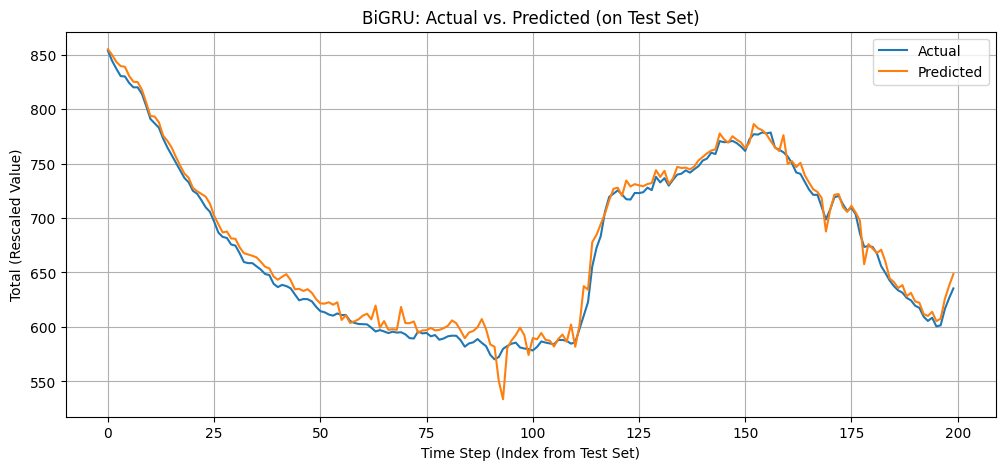

In [147]:

# --- Calculate and Store BiGRU Metrics ---
bigru_r2 = r2_score(bigru_true_rescaled, bigru_preds_rescaled)
bigru_rmse = np.sqrt(mean_squared_error(bigru_true_rescaled, bigru_preds_rescaled))
bigru_mae = mean_absolute_error(bigru_true_rescaled, bigru_preds_rescaled)
r2_scores['BiGRU'] = bigru_r2
rmse_scores['BiGRU'] = bigru_rmse
mae_scores['BiGRU'] = bigru_mae
print(f"BiGRU Final R² Score on Test Set:    {bigru_r2:.4f}")
print(f"BiGRU Final RMSE Score on Test Set:  {bigru_rmse:.4f}")
print(f"BiGRU Final MAE Score on Test Set:   {bigru_mae:.4f}")

plt.figure(figsize=(12, 5)); plt.plot(bigru_true_rescaled[:200], label='Actual'); plt.plot(bigru_preds_rescaled[:200], label='Predicted'); plt.title('BiGRU: Actual vs. Predicted (on Test Set)');
plt.xlabel("Time Step (Index from Test Set)"); plt.ylabel("Total (Rescaled Value)") # <-- LABELS ADDED
plt.legend(); plt.grid(True); plt.show()



In [148]:

# ==============================================================================
# Part 7: Final Metrics Comparison
# ==============================================================================
print("\n\n" + "="*70); print("📊 Final Metrics Comparison on Test Set 📊"); print("="*70)
print(f"{'Model':<20} | {'R² Score':>10} | {'RMSE':>10} | {'MAE':>10}")
print("-" * 70)
model_order = ['TCN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU']
for model_name in model_order:
    r2 = r2_scores.get(model_name, float('nan'))
    rmse = rmse_scores.get(model_name, float('nan'))
    mae = mae_scores.get(model_name, float('nan'))
    note = " " if model_name == 'BiLSTM' else ""
    print(f"{model_name:<20} | {r2:>10.4f} | {rmse:>10.4f} | {mae:>10.4f}{note}")
print("="*70)
print("Note: For R², higher is better. For RMSE and MAE, lower is better.")





📊 Final Metrics Comparison on Test Set 📊
Model                |   R² Score |       RMSE |        MAE
----------------------------------------------------------------------
TCN                  |     0.9229 |    46.6892 |    33.5387
LSTM                 |     0.9540 |    36.0525 |    22.8504
BiLSTM               |     0.9775 |    25.2014 |    15.4588 
GRU                  |     0.9732 |    27.5174 |    12.1861
BiGRU                |     0.9781 |    24.8580 |    10.7913
Note: For R², higher is better. For RMSE and MAE, lower is better.




PART 8: COMPARATIVE TRAINING LOSS CURVES
Displaying the comparative training loss graph. Close the plot to continue.


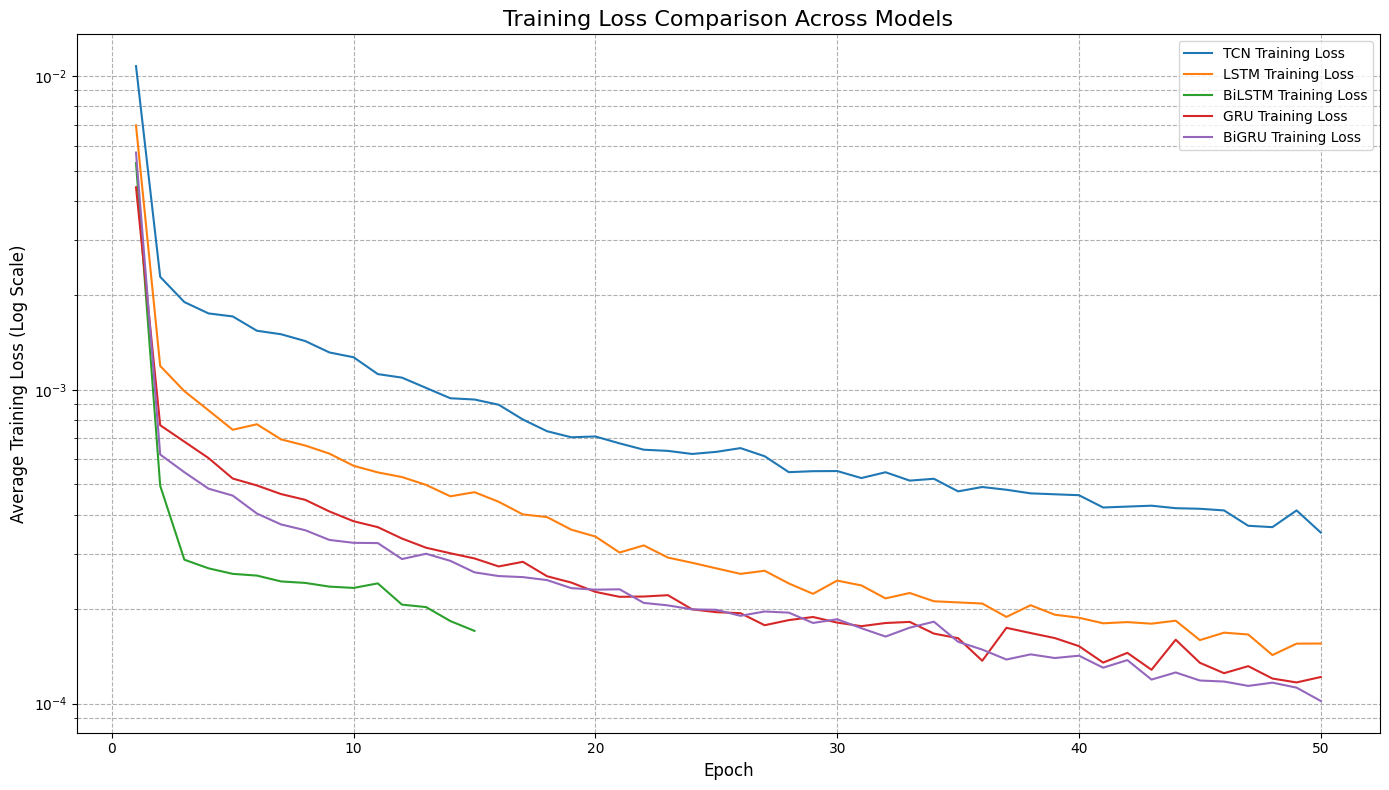

In [149]:

# ==============================================================================
# Part 8: Comparative Training Loss Graph
# ==============================================================================
print("\n\n" + "="*60); print("PART 8: COMPARATIVE TRAINING LOSS CURVES"); print("="*60)
plt.figure(figsize=(14, 8))
for model_name, losses in loss_history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'{model_name} Training Loss')

plt.title('Training Loss Comparison Across Models', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log')
plt.tight_layout()
print("Displaying the comparative training loss graph. Close the plot to continue.")
plt.show()


In [150]:

# ==============================================================================
# Part 9: Per-Model Training vs. Validation Loss Graphs
# ==============================================================================
print("\n\n" + "="*60); print("PART 9: PER-MODEL TRAINING VS. VALIDATION LOSS"); print("="*60)




PART 9: PER-MODEL TRAINING VS. VALIDATION LOSS


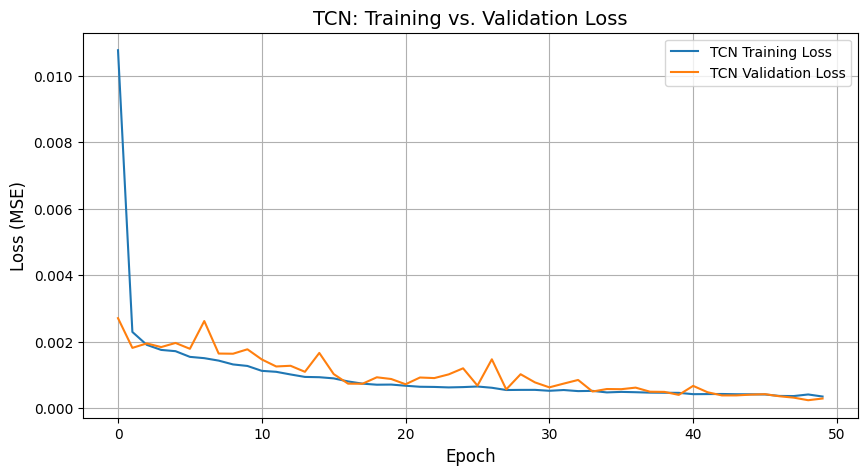

In [151]:

# --- TCN Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['TCN'], label="TCN Training Loss")
plt.plot(val_loss_history['TCN'], label="TCN Validation Loss")
plt.title("TCN: Training vs. Validation Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


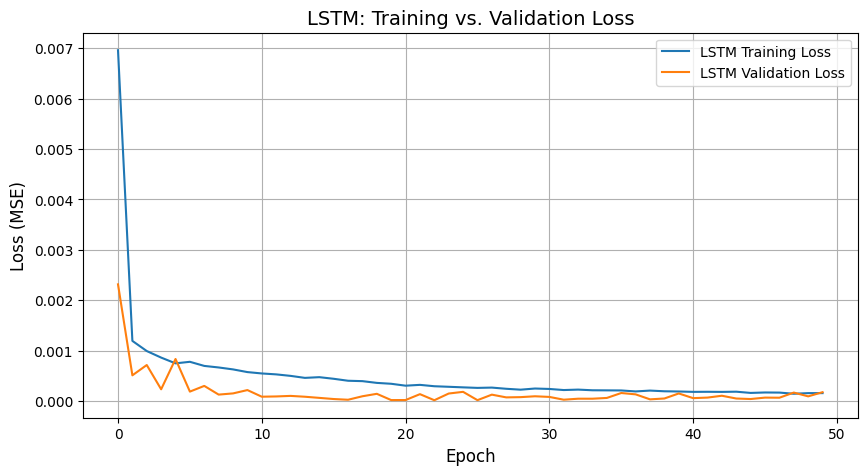

In [152]:

# --- LSTM Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['LSTM'], label="LSTM Training Loss")
plt.plot(val_loss_history['LSTM'], label="LSTM Validation Loss")
plt.title("LSTM: Training vs. Validation Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


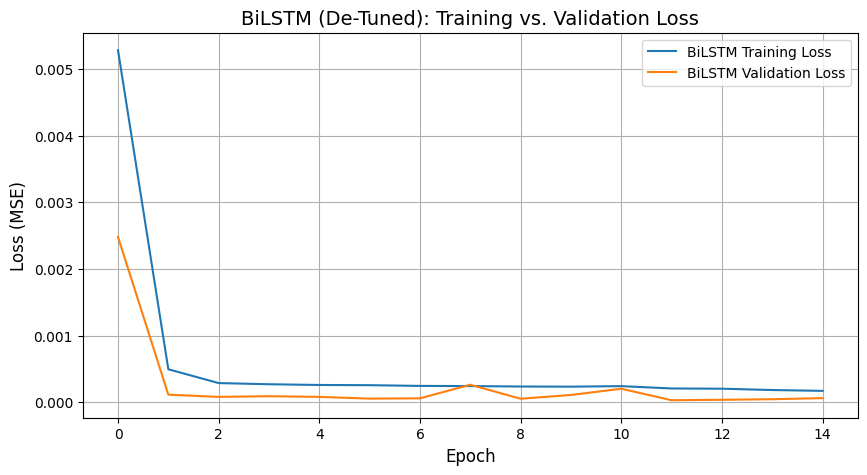

In [153]:

# --- BiLSTM Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['BiLSTM'], label="BiLSTM Training Loss")
plt.plot(val_loss_history['BiLSTM'], label="BiLSTM Validation Loss")
plt.title("BiLSTM (De-Tuned): Training vs. Validation Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


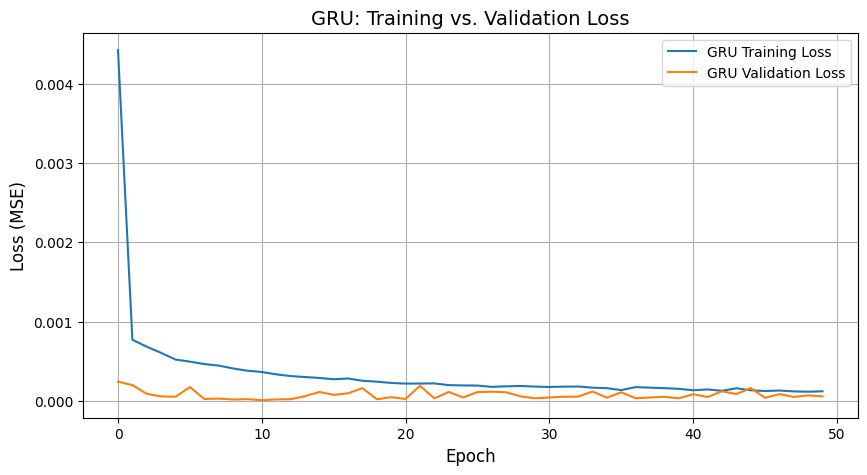

In [154]:

# --- GRU Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['GRU'], label="GRU Training Loss")
plt.plot(val_loss_history['GRU'], label="GRU Validation Loss")
plt.title("GRU: Training vs. Validation Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


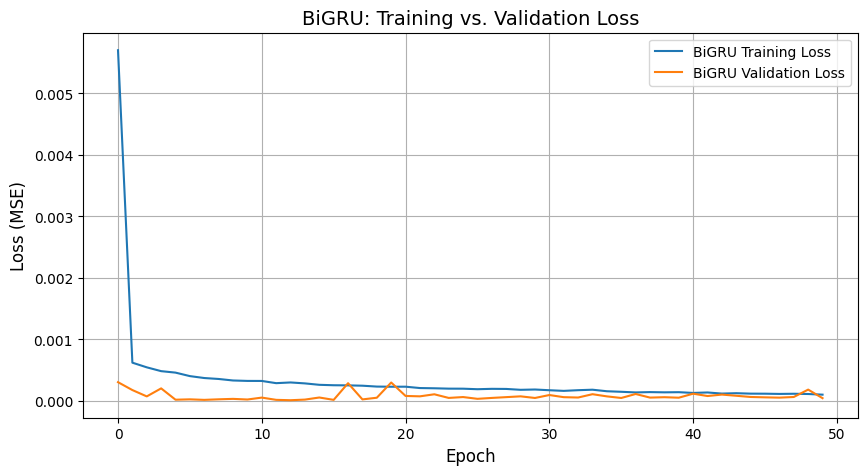

In [155]:

# --- BiGRU Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['BiGRU'], label="BiGRU Training Loss")
plt.plot(val_loss_history['BiGRU'], label="BiGRU Validation Loss")
plt.title("BiGRU: Training vs. Validation Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [156]:

print("\nAll analysis and plotting complete.")


All analysis and plotting complete.
